Simulação de Monte carlo

 - Criada durante a segunda Guerra mundial
 - Nomeada em homenagem a a cidade de Mônaco com seus cassinos
 - Foi criada inicialmente para testar cenários do jogo de paciência
 - Usada para estimar ppossíveis resultados de um cenário incerto.O acaso é o principal elemento da abordagem na modelagem
     - No mercado financeiro, existem tantos cenários, que a projeção de retornos não pode ser resolvida por uma simples   análise combinatória. É preciso resolver o problema usando força bruta, simular o cenário N vezes, criando uma amostra e, a partir da amostra, praticar a interferência estatistica.

Problema a ser resolvido:

- Tenho uma carteira com 05 ações. Dado a distribuição dos retornos dessa carteira no ultimo ano:
    - Qual o máximo que eu posso porder nos próximos 3 anos, com uma confiança de 95%?
    - Qual a probabilidade de eu obter lucro?

 Resolução:
 
 - Vamos simular 10 mil cenários da carteira com 05 ações nos próximos 03 anos e criar uma distribuiçãop de retornos com os cenários. Para isso, vamos utilizar Monte Carlo.

In [14]:
!pip install pandas_datareader
!pip install yfinance

     ---------------------------------------- 60.3/60.3 kB 3.3 MB/s eta 0:00:00
     -------------------------------------- 112.2/112.2 kB 6.4 MB/s eta 0:00:00


In [22]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
from numpy import linalg as LA

In [23]:
# Pegando dados

yf.pdr_override()

lista_acoes = ['WEGE3', 'PCAR3', 'LREN3', 'PETR4', 'VALE3'] # Lista de 5 acoes
lista_acoes = [acao + ".SA" for acao in lista_acoes] # List comprehension para adicionar .SA no final de cada acao da lista de acoes

data_final = dt.datetime.now()
data_inicial = data_final - dt.timedelta(days=300)

precos = pdr.get_data_yahoo(lista_acoes, start=data_inicial, end=data_final)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [32]:
# Calculando retornos pegando matriz de covariançia

retornos = precos.pct_change().dropna()
matriz_covariancia = retornos.cov()
pesos_carteira = np.full(len(lista_acoes), 1/len(lista_acoes))
numero_acoes = len(lista_acoes)


Formula retornos sintéticos

Retornos_sinteticos = media_retornos + Rpdf * L 

- media_retornos = Média dos retornos
- Rpdf = Matriz aleatória gerada por alguma função de densidade de probabilidade
- L = Matriz triangular inferior proveniente de uma decomposição de cholesky, usando como base a matriz de covariância dos dados originais


Por que fazer isso ?

Nós assumimos que a distribuição de retornos é um distribuição normal multivariada (isso é uma expasão da distribuição normal).

Quando geramos retornos aleatórios de cada ativo (weg, vale, etc.) nós criamos vetores aleatórios descorrelacionados entre si. Para corrigir isso, precisamos correlacionar esses retornos (no mundo real isso é o que acontece) e, para isso, usamos a matriz triângular obtida a partir da covariância.


In [31]:
# premissias monte carlo

numero_simulacoes = 10000
dias_projetados = 252 * 3
capital_inicial = 1000

In [33]:
# Gerando retorno médio

retorno_medio = retornos.mean(axis=0).to_numpy() # tranformando o retorno medio em um array
matriz_retorno_medio = retorno_medio * np.ones(shape = (dias_projetados, numero_acoes))

In [41]:
# Gerando L -> Matriz triangular proveniente de uam decomposição de Cholesky

L = LA.cholesky(matriz_covariancia)


In [43]:
# Gerando simulações

retornos_carteira = np.zeros([dias_projetados, numero_simulacoes]) # Gera uma matriz com as dimensões determinadas [dias_projetados = linhas, numero_simulacoes = colunas]
montante_final = np.zeros(numero_simulacoes) 

for s in range(numero_simulacoes): 
    
    Rpdf = np.random.normal(size=(dias_projetados, numero_acoes)) # Gera o Rpdf (matriz aleatória) com as dimensões determinadas dias_projetados = linhas, numero_acoes = colunas
    
    retornos_sinteticos = matriz_retorno_medio + np.inner(Rpdf, L) # essa linha aplica a formula de retornos sintéricos pegando a matriz de retorno médio e somando com a multiplicação de matriz ( retornos_sinteticos = media_retornos + Rpdf * L)
    
    retornos_carteira[:, s] = np.cumprod(np.inner(pesos_carteira, retornos_sinteticos) +1) * capital_inicial
    montante_final[s] = retornos_carteira[-1,s]
    
retornos_carteira

array([[1023.15365861, 1040.93569142, 1009.02697156, ..., 1042.88170839,
         997.51744166, 1017.04750577],
       [1020.54135221, 1073.86363912, 1012.86719926, ..., 1070.08943381,
        1003.10012089, 1038.35344549],
       [1021.67391559, 1081.13793668, 1021.40311027, ..., 1079.50853425,
         991.49603076, 1065.18342181],
       ...,
       [ 947.1355185 , 1320.03883679, 1237.70036152, ..., 2372.75162892,
        1120.74737687, 1459.96143508],
       [ 955.38276992, 1340.59904451, 1215.73104304, ..., 2415.49975633,
        1067.17712013, 1500.41073823],
       [ 936.97570239, 1355.27238503, 1215.30955702, ..., 2463.75039752,
        1083.31938351, 1464.71070997]])

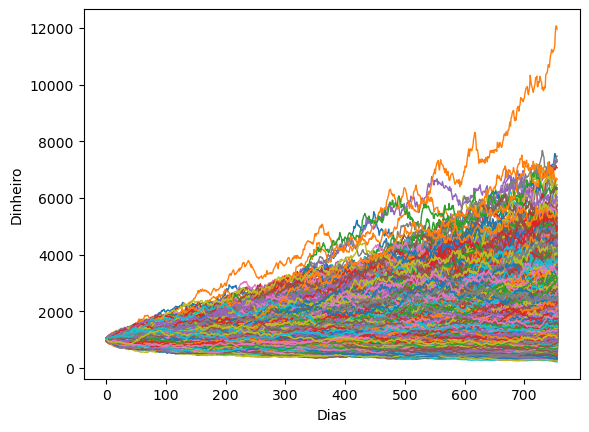

In [44]:
plt.plot(retornos_carteira, linewidth=1)
plt.ylabel('Dinheiro')
plt.xlabel('Dias')
plt.show()

In [45]:
montante_99 = str(np.percentile(montante_final,1))
montante_95 = str(np.percentile(montante_final,5))
montante_mediano = str(np.percentile(montante_final,50))
cenarios_com_lucro = str((len(montante_final[montante_final > 1000])/len(montante_final)) * 100) + "%"

In [49]:
print(f'''Ao investir R$1000,00 na carteira {lista_acoes},
podemos esperar esses resultados para os próximos 3 anos,
utilizando o método Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que {montante_mediano}.

Com 95% de probabilidade, o montante será maior que {montante_95}.

com 99% de probabilidade, o montante será maior que {montante_99}.

Em {cenarios_com_lucro} dos cenários, foi possível obter lucro nos próximos 3 anos.''')

Ao investir R$1000,00 na carteira ['WEGE3.SA', 'PCAR3.SA', 'LREN3.SA', 'PETR4.SA', 'VALE3.SA'],
podemos esperar esses resultados para os próximos 3 anos,
utilizando o método Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que 1560.2922754631074.

Com 95% de probabilidade, o montante será maior que 727.9542668012543.

com 99% de probabilidade, o montante será maior que 529.6742169167165.

Em 83.57% dos cenários, foi possível obter lucro nos próximos 3 anos.
